In [1]:
import requests
from io import BytesIO
from zipfile import ZipFile
dataset = requests.get("https://www.dropbox.com/s/04r31l2whoyljz7/trafficsigns.zip?dl=1")
with ZipFile(BytesIO(dataset.content)) as z:
  z.extractall(".")
classlabels = requests.get("https://www.dropbox.com/s/lte4x88xdk9x4k2/classlabels.txt?dl=1")
with open("classlabels.txt", 'w') as outfile:
  outfile.write(classlabels.content.decode('utf-8'))

In [2]:
from tensorflow.keras.utils import load_img, image_dataset_from_directory
training_set = [(i, l) for i, l in image_dataset_from_directory('trafficsigns/train', image_size = (128, 128), batch_size = None, seed = 123)]
test_set = [(i, l) for i, l in image_dataset_from_directory('trafficsigns/test', image_size = (128, 128), batch_size = None, seed = 123)]

import json
with open("classlabels.txt") as infile:
  labels = dict((int(i), j) for i, j in json.loads(infile.read()).items())
print("The 20 classes are: " + ", ".join(str(l) for l in labels.values()))

Found 1792 files belonging to 20 classes.
Found 1022 files belonging to 20 classes.
The 20 classes are: limit30, limit50, limit60, limit80, noleft, noright, nouturn, gostraight, goleft, goright, keepright, roundabout, danger, pedestrcross, bikecross, childcross, traincross, construction, nostopping, noentry


In [3]:
labels_to_keep = list(range(20)) # Change this to determine which labels to keep (or change to list(range(20)) to keep all labels)
num_classes = len(labels_to_keep)

import numpy as np
x_train = np.array([image for image, label in training_set if label in labels_to_keep])
y_train = np.array([labels_to_keep.index(label) for image, label in training_set if label in labels_to_keep])
x_test = np.array([image for image, label in test_set if label in labels_to_keep])
y_test = np.array([labels_to_keep.index(label) for image, label in test_set if label in labels_to_keep])

finallabels = dict([(i, labels[l]) for i, l in enumerate(labels_to_keep)])
print("The " + str(num_classes) + " classes are: " + ", ".join(str(l) for l in finallabels.values()))

The 20 classes are: limit30, limit50, limit60, limit80, noleft, noright, nouturn, gostraight, goleft, goright, keepright, roundabout, danger, pedestrcross, bikecross, childcross, traincross, construction, nostopping, noentry


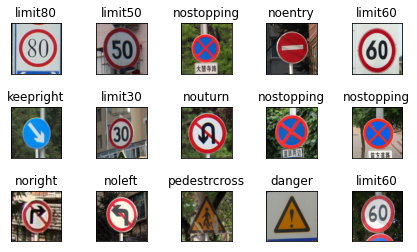

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import array_to_img
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  img = array_to_img(x_train[i])
  plt.imshow(img)
  plt.title(finallabels[y_train[i]])
  plt.xticks([])
  plt.yticks([])

### Explore Data

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
import random
import cv2
import math
import seaborn as sns
import tempfile
import os
import datetime

from psutil import virtual_memory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Input, RandomRotation, RandomZoom, RandomBrightness, RandomContrast, RandomCrop, Concatenate, BatchNormalization, CenterCrop, PReLU, ReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, TensorBoard, LearningRateScheduler, TensorBoard
from tensorflow.keras.utils import to_categorical, plot_model, model_to_dot
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import Sequential
from sklearn.metrics import classification_report, accuracy_score

In [6]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [7]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jan  6 22:41:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    26W /  70W |    314MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [9]:
unique, counts = np.unique(y_train, return_counts=True)
max_value = counts.max()
scales = [ (max_value/i) for i in counts ]
percentages = [ (i/max_value) for i in counts ]
scales = dict(zip(unique, scales))

In [10]:
target_names = []
for i in labels:
  target_names.append(labels[i])

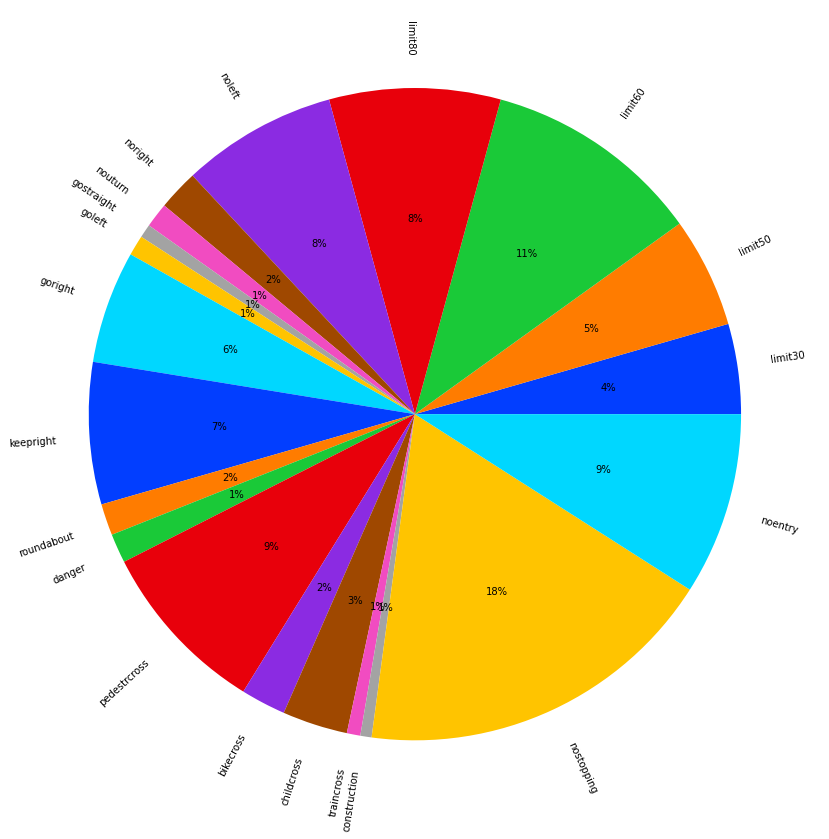

In [11]:
# Seaborn color palette to plot pie chart
plt.figure(figsize=(15,15))
colors = sns.color_palette('bright')
plt.pie(percentages, labels=target_names, colors=colors,autopct='%.0f%%', shadow=False, rotatelabels='true')
plt.show()

In [12]:
scales

{0: 4.05,
 1: 3.306122448979592,
 2: 1.6701030927835052,
 3: 2.1315789473684212,
 4: 2.347826086956522,
 5: 9.0,
 6: 14.727272727272727,
 7: 27.0,
 8: 18.0,
 9: 3.24,
 10: 2.5714285714285716,
 11: 11.571428571428571,
 12: 12.461538461538462,
 13: 2.076923076923077,
 14: 8.1,
 15: 5.586206896551724,
 16: 27.0,
 17: 32.4,
 18: 1.0,
 19: 2.0}

In [13]:
unique_test, counts_test = np.unique(y_test, return_counts=True)
max_value_test = counts_test.max()
scales_test = [ (max_value_test/i) for i in counts_test ]
percentages_test = [ (i/max_value_test) for i in counts_test ]
scales_test = dict(zip(unique_test, scales_test))

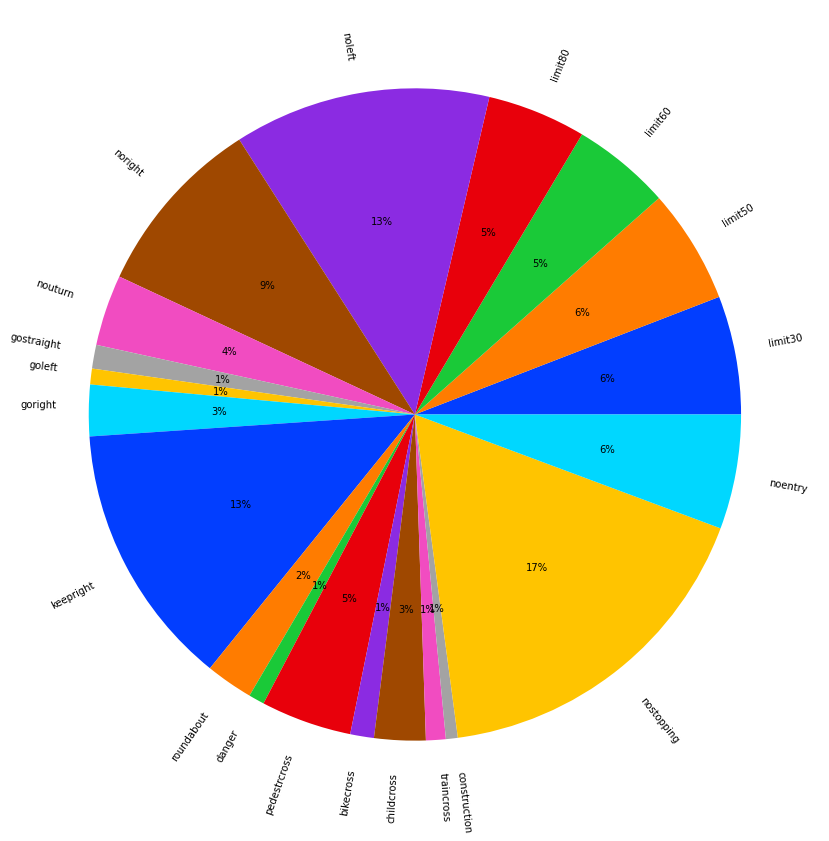

In [14]:
# Seaborn color palette to plot pie chart
plt.figure(figsize=(15,15))
colors = sns.color_palette('bright')
plt.pie(percentages_test, labels=target_names, colors=colors,autopct='%.0f%%', shadow=False, rotatelabels='true')
plt.show()

Text(0.5, 1.0, 'Number of images of each target class on Training and Test set')

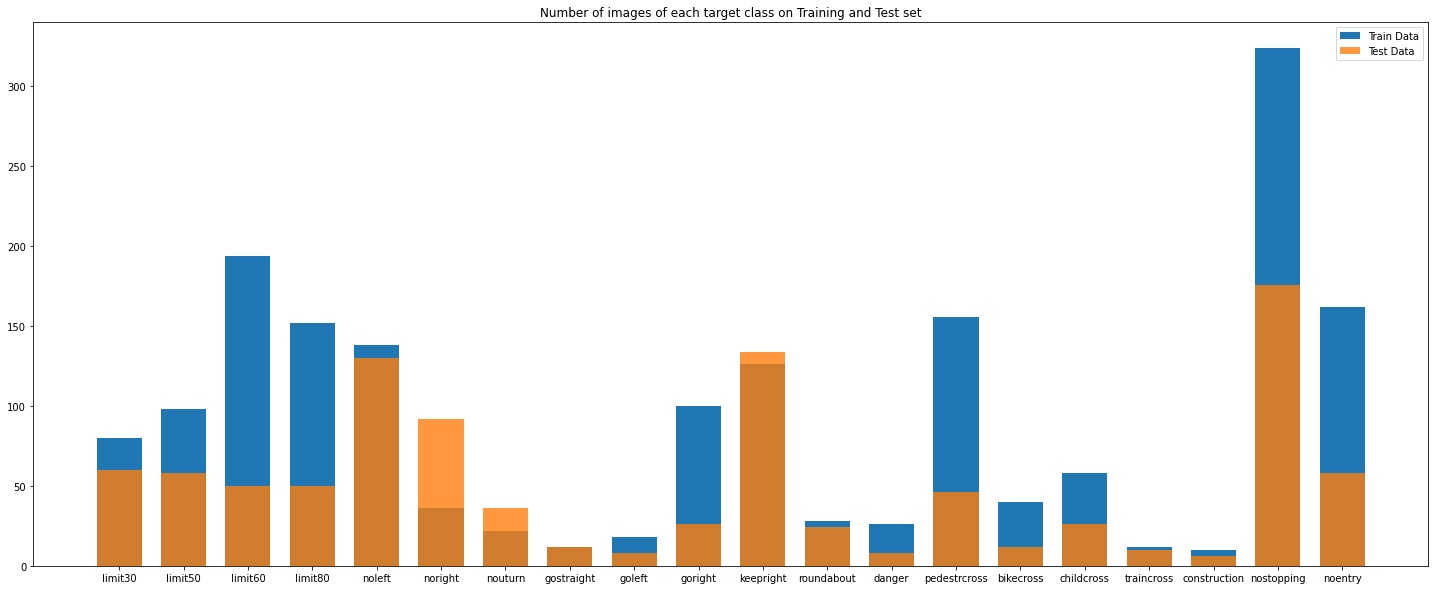

In [15]:
plt.figure(figsize=(25,10))
plt.bar(target_names, counts, align='center', width=0.7, label='Train Data')
plt.bar(target_names, counts_test, align='center', width=0.7, alpha=0.8, label='Test Data')
plt.legend();
plt.title("Number of images of each target class on Training and Test set")

In [16]:
scales_test

{0: 2.933333333333333,
 1: 3.0344827586206895,
 2: 3.52,
 3: 3.52,
 4: 1.353846153846154,
 5: 1.9130434782608696,
 6: 4.888888888888889,
 7: 14.666666666666666,
 8: 22.0,
 9: 6.769230769230769,
 10: 1.3134328358208955,
 11: 7.333333333333333,
 12: 22.0,
 13: 3.8260869565217392,
 14: 14.666666666666666,
 15: 6.769230769230769,
 16: 17.6,
 17: 29.333333333333332,
 18: 1.0,
 19: 3.0344827586206895}

As we can see the data are little unbalanced

In [17]:
y_train

array([ 3,  1, 18, ...,  9, 18, 18])

As we can see target data need one hot encoding

In [18]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [19]:
x_train_gray = (x_train/255)
x_test_gray = (x_test/255)

Scale to [-1,1] because both of the pretrained models of tensorflow required them as such

In [20]:
x_train_color = (x_train/127.5)-1
x_test_color = (x_test/127.5)-1

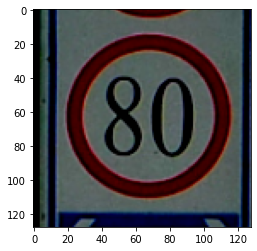

In [21]:
plt.imshow(x_train_color[0])

In [22]:
x_train_gray = np.asarray([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in x_train_gray]).reshape(1792,128,128,1)
x_test_gray = np.asarray([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in x_test_gray]).reshape(1022,128,128,1)

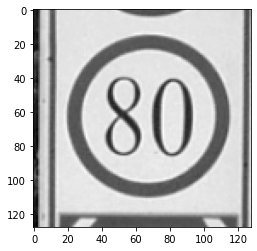

In [23]:
plt.imshow(x_train_gray[0].reshape(128,128), cmap='gray')

In [58]:
adam_lr = 0.0002 #@param {type:"slider", min:0.000001, max: 0.001, step:0.000001}
rotation_factor = 0.13 #@param {type:"slider", min:0, max: 0.2, step:0.01}
zoom_factor = 0.2 #@param {type:"slider", min:0, max: 0.3, step:0.01}
brightness_factor = 0.5 #@param {type:"slider", min:0, max: 1, step:0.05}

In [59]:
preprocessing_layers = Sequential([
  RandomCrop(height=100, width=100),
  RandomBrightness(factor=brightness_factor, value_range=(-1, 1)),
  RandomRotation(factor=rotation_factor),
  RandomZoom(height_factor=zoom_factor, width_factor=zoom_factor)
])

preprocessing_layers_gray = Sequential([
  RandomCrop(height=100, width=100),
  RandomBrightness(factor=brightness_factor, value_range=(0, 1)),
  RandomRotation(factor=rotation_factor),
  RandomZoom(height_factor=zoom_factor, width_factor=zoom_factor)
])

test_prerpocessing_layer = Sequential([
    CenterCrop(height=100, width=100)
])

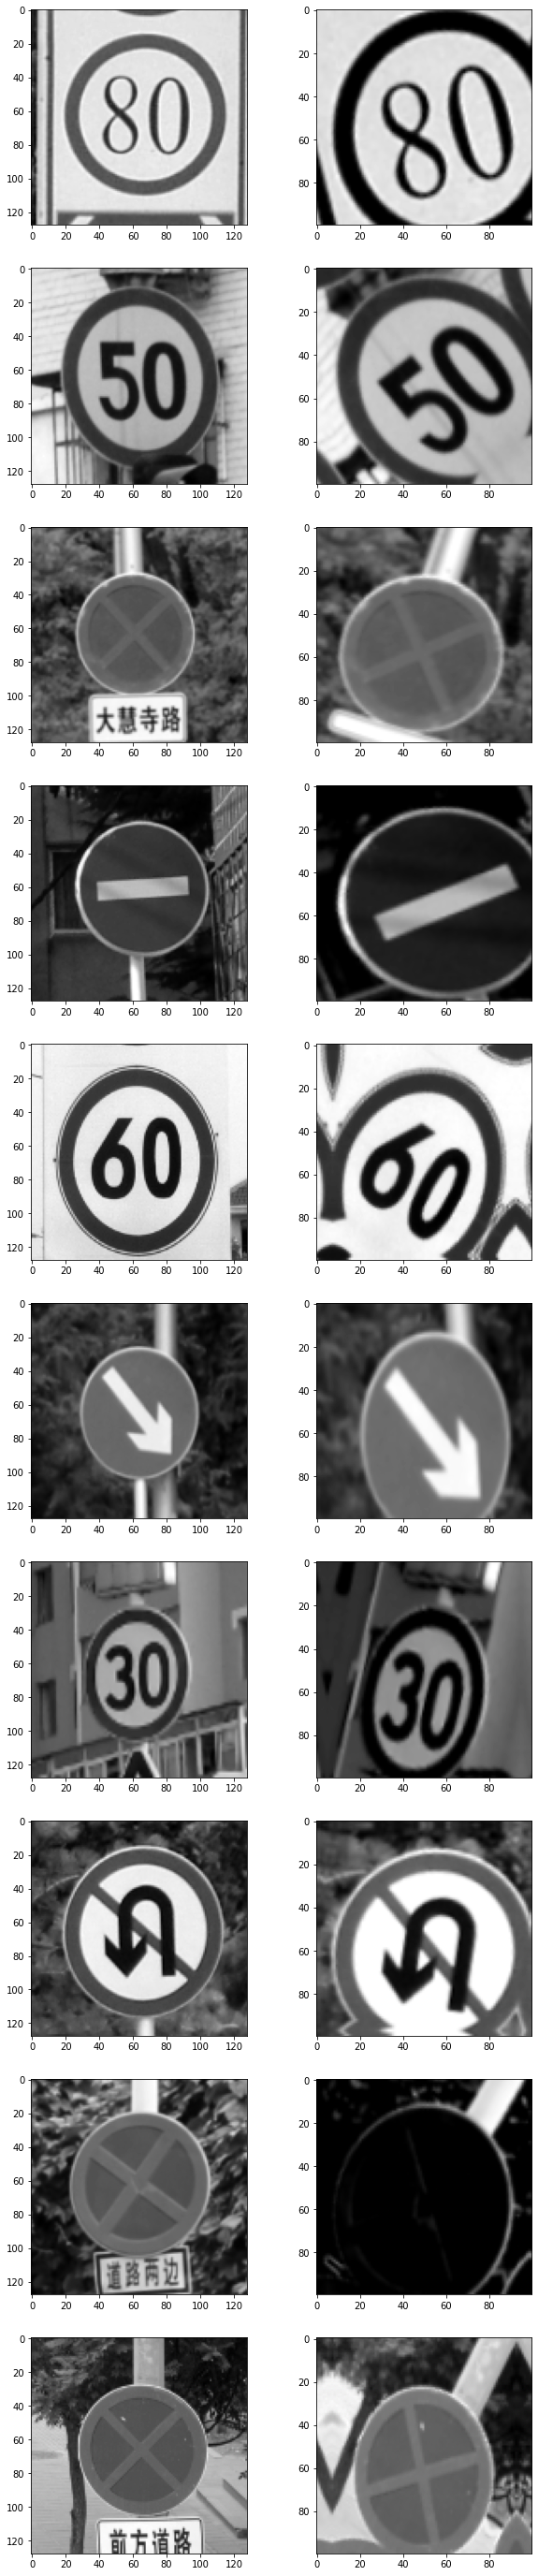

In [60]:
rows = 10;
images = preprocessing_layers_gray(x_train_gray[0:rows], training=True).numpy();
fig, axs = plt.subplots(rows, 2, figsize=(10, rows*5));

for i in range(rows):
  axs[i,0].imshow(x_train_gray[i].reshape(128,128), cmap='gray');
  axs[i,1].imshow(images[i].reshape(100,100), cmap='gray');

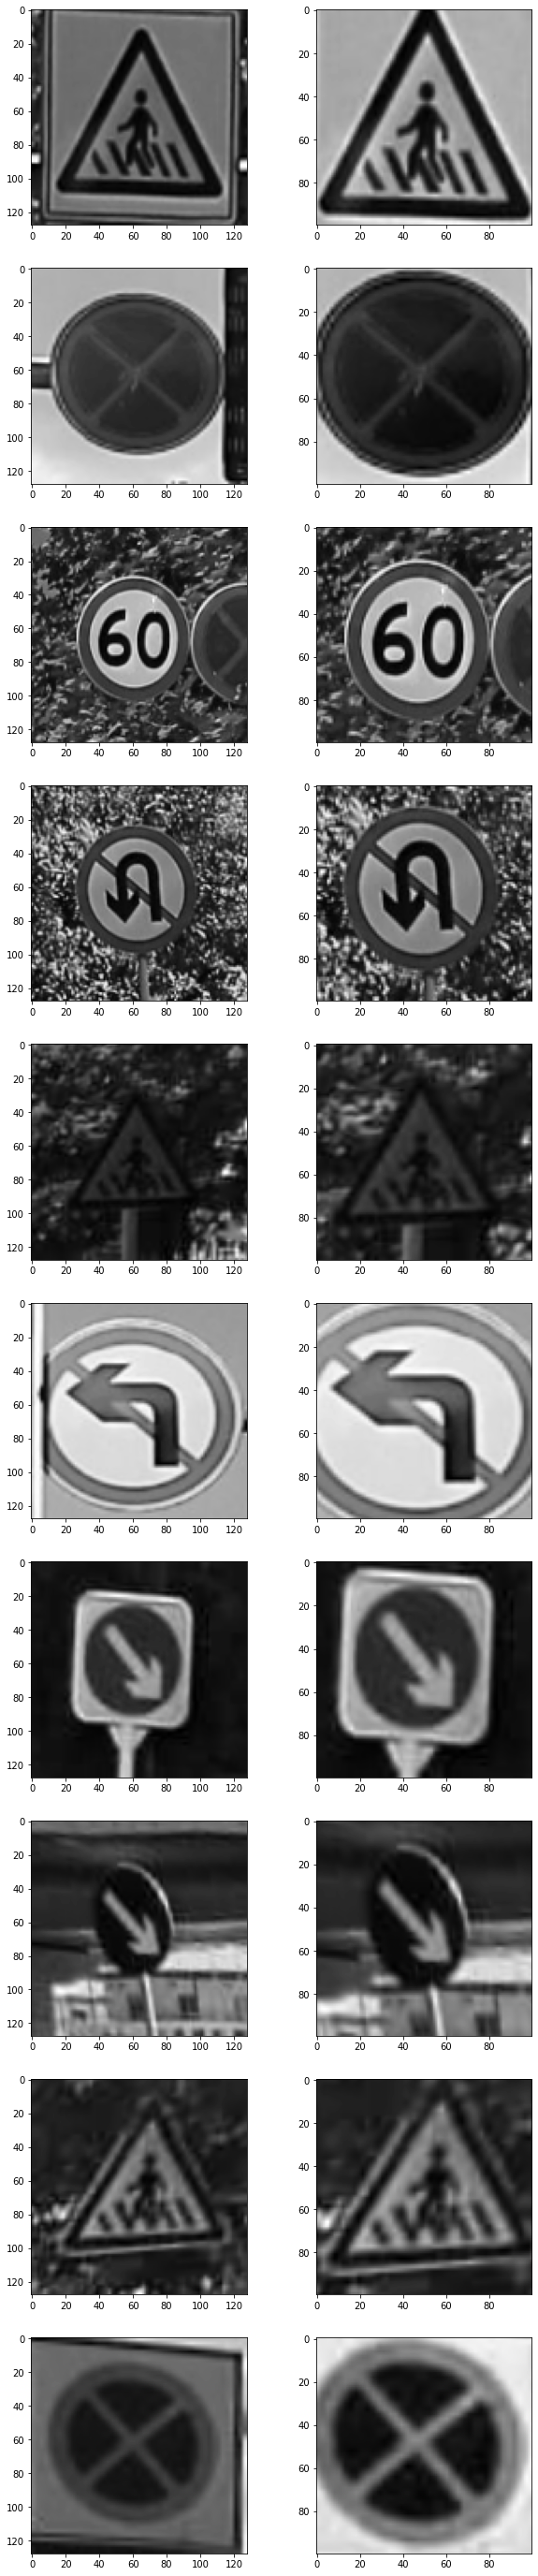

In [61]:
images_test = test_prerpocessing_layer(x_test_gray[0:rows], training=True).numpy();
fig, axs = plt.subplots(rows, 2, figsize=(10, rows*5));

for i in range(rows):
  axs[i,0].imshow(x_test_gray[i].reshape(128,128), cmap='gray');
  axs[i,1].imshow(images_test[i].reshape(100,100), cmap='gray');

In [62]:
adam = Adam(learning_rate = 0.0002);

In [63]:
InceptionResNet = InceptionResNetV2(
    include_top=False,
    input_shape=(100,100,3),
    pooling='max'
)

In [64]:
EfficientNet = EfficientNetV2M(
    include_top=False,
    input_shape=(100,100,3),
    pooling='max',
)

In [65]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_color, y_train))
train_dataset_gray = tf.data.Dataset.from_tensor_slices((x_train_gray, y_train))

In [66]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_color, y_test))
test_dataset_gray = tf.data.Dataset.from_tensor_slices((x_test_gray, y_test))

In [67]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.batch(batch_size);
train_dataset = train_dataset.map(lambda x, y: (preprocessing_layers(x, training=True), y));
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

train_dataset_gray = train_dataset_gray.batch(batch_size);
train_dataset_gray = train_dataset_gray.map(lambda x, y: (preprocessing_layers_gray(x, training=True), y));
train_dataset_gray = train_dataset_gray.prefetch(buffer_size=AUTOTUNE)

In [68]:
test_dataset = test_dataset.batch(batch_size).map(lambda x, y: (test_prerpocessing_layer(x, training=True), y));
test_dataset_gray = test_dataset_gray.batch(batch_size).map(lambda x, y: (test_prerpocessing_layer(x, training=True), y));

In [69]:
def step_decay(epoch, lr):
  if epoch > 5:
    lr *= 0.95
  return lr

lrate_decay = LearningRateScheduler(step_decay);

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose=1, factor=0.5, min_lr=10e-7);

early_stop = EarlyStopping(
    monitor="val_accuracy",
    min_delta=10e-4,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


In [70]:
input = Input(shape=(100,100,3))
x = EfficientNet(input)
x = Dense(524, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(20, activation='softmax')(x)

pretrained_model = Model(input, output)

pretrained_model.compile(loss=CategoricalCrossentropy(label_smoothing=0.1),
              optimizer=adam,
              metrics=['accuracy'])

In [71]:
pretrained_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 efficientnetv2-m (Functiona  (None, 1280)             53150388  
 l)                                                              
                                                                 
 dense_12 (Dense)            (None, 524)               671244    
                                                                 
 dropout_9 (Dropout)         (None, 524)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               134400    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                          

In [72]:
history_pretrained = pretrained_model.fit(train_dataset, epochs=200, callbacks=[reduce_lr, early_stop], class_weight=scales, validation_data=test_dataset)

Epoch 1/200
56/56 [==============================] - 51s 416ms/step - loss: 11.3094 - accuracy: 0.0871 - val_loss: 2.7252 - val_accuracy: 0.1957 - lr: 2.0000e-04
Epoch 2/200
56/56 [==============================] - 18s 321ms/step - loss: 9.6650 - accuracy: 0.2941 - val_loss: 2.0000 - val_accuracy: 0.4560 - lr: 2.0000e-04
Epoch 3/200
56/56 [==============================] - 18s 329ms/step - loss: 7.7545 - accuracy: 0.4520 - val_loss: 1.7058 - val_accuracy: 0.5851 - lr: 2.0000e-04
Epoch 4/200
56/56 [==============================] - 19s 336ms/step - loss: 6.7540 - accuracy: 0.6071 - val_loss: 1.3177 - val_accuracy: 0.7202 - lr: 2.0000e-04
Epoch 5/200
56/56 [==============================] - 19s 334ms/step - loss: 4.9807 - accuracy: 0.7667 - val_loss: 1.1993 - val_accuracy: 0.7750 - lr: 2.0000e-04
Epoch 6/200
56/56 [==============================] - 18s 322ms/step - loss: 4.3010 - accuracy: 0.8387 - val_loss: 1.6002 - val_accuracy: 0.6301 - lr: 2.0000e-04
Epoch 7/200
56/56 [==============

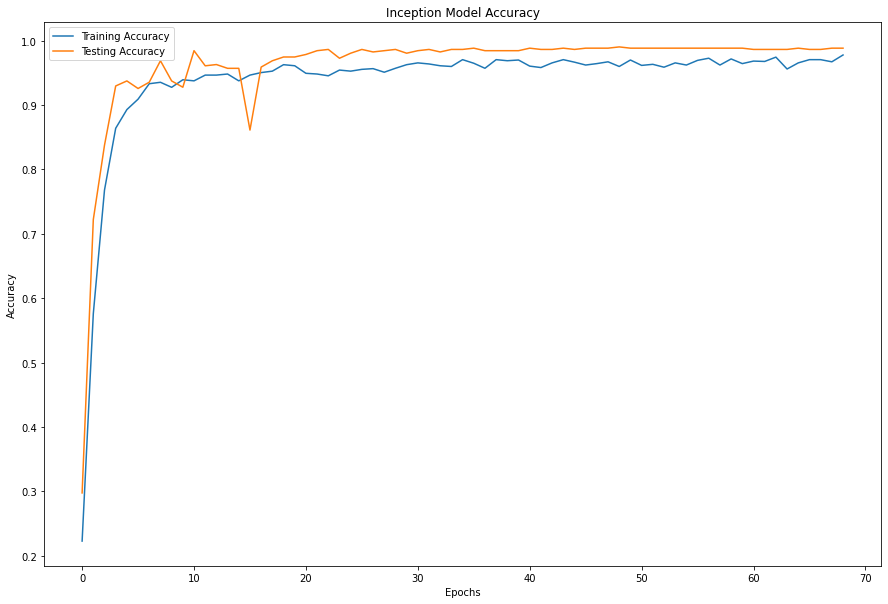

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(history_pretrained.history['accuracy']);
plt.plot(history_pretrained.history['val_accuracy']);
plt.legend(['Training Accuracy', 'Testing Accuracy']);
plt.title('Inception Model Accuracy');
plt.ylabel('Accuracy');
plt.xlabel('Epochs');

In [79]:
adam = Adam(learning_rate = adam_lr);
sgd = SGD(learning_rate=0.001)
rmsprop = RMSprop(learning_rate=0.0001)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=15, verbose=1, factor=0.5, min_lr=10e-7);

early_stop = EarlyStopping(
    monitor="val_accuracy",
    min_delta=10e-4,
    patience=30,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + 'RMSprop-0.0001-BatchNorm';
# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [80]:
input = Input(shape=(100,100,1))
x = Conv2D(32, (6,6))(input)
x = BatchNormalization()(x, training=True)
x = PReLU()(x)
x = Conv2D(32, (6,6))(x)
x = BatchNormalization()(x, training=True)
x = PReLU()(x)
x = Conv2D(32, (6,6))(x)
x = BatchNormalization()(x, training=True)
x = PReLU()(x)
x = Dropout(0.1)(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3,3))(x)
x = BatchNormalization()(x, training=True)
x = PReLU()(x)
x = Conv2D(64, (3,3))(x)
x = BatchNormalization()(x, training=True)
x = PReLU()(x)
x = Dropout(0.1)(x)
x = Conv2D(64, (3,3))(x)
x = BatchNormalization()(x, training=True)
x = PReLU()(x)
split = Flatten()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(32, (3,3))(x)
x = BatchNormalization()(x, training=True)
x = PReLU()(x)
x = Flatten()(x)
x = Concatenate(axis=1)([x, split])
x = Dense(524)(x)
x = PReLU()(x)
x = Dense(256)(x)
x = PReLU()(x)
x = Dense(124)(x)
x = PReLU()(x)
x = Dropout(0.4)(x)
output = Dense(20, activation='softmax')(x)

classification_model = Model(input, output)

classification_model.compile(loss=CategoricalCrossentropy(label_smoothing=0.1),
              optimizer=rmsprop,
              metrics=['accuracy'])

In [81]:
classification_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_420 (Conv2D)            (None, 95, 95, 32)   1184        ['input_9[0][0]']                
                                                                                                  
 batch_normalization_420 (Batch  (None, 95, 95, 32)  128         ['conv2d_420[0][0]']             
 Normalization)                                                                                   
                                                                                           

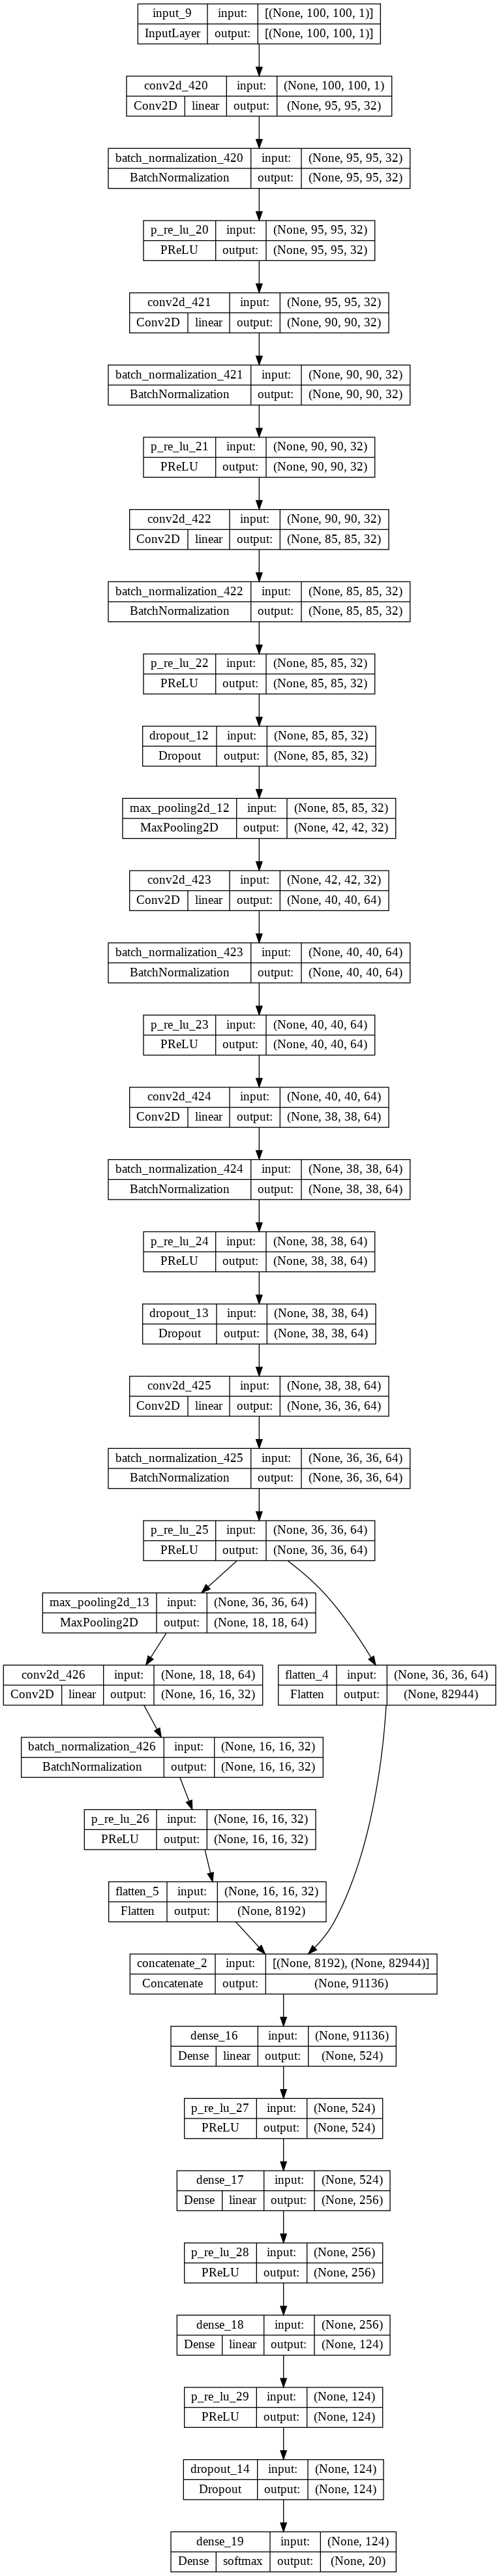

In [82]:
plot_model(classification_model, show_shapes=True, rankdir="TB", show_layer_activations=True)

In [ ]:
history = classification_model.fit(train_dataset_gray, epochs=500, callbacks=[reduce_lr, early_stop], class_weight=scales, validation_data=test_dataset_gray)

Epoch 1/500
56/56 [==============================] - 11s 147ms/step - loss: 13.8401 - accuracy: 0.0737 - val_loss: 2.8883 - val_accuracy: 0.1477 - lr: 1.0000e-04
Epoch 2/500
56/56 [==============================] - 8s 138ms/step - loss: 11.2032 - accuracy: 0.0859 - val_loss: 2.7876 - val_accuracy: 0.2104 - lr: 1.0000e-04
Epoch 3/500
56/56 [==============================] - 8s 136ms/step - loss: 11.0413 - accuracy: 0.1027 - val_loss: 2.8502 - val_accuracy: 0.2016 - lr: 1.0000e-04
Epoch 4/500
56/56 [==============================] - 8s 135ms/step - loss: 10.9222 - accuracy: 0.0988 - val_loss: 2.7901 - val_accuracy: 0.0822 - lr: 1.0000e-04
Epoch 5/500
56/56 [==============================] - 8s 135ms/step - loss: 10.9180 - accuracy: 0.1177 - val_loss: 2.7053 - val_accuracy: 0.1448 - lr: 1.0000e-04
Epoch 6/500
56/56 [==============================] - 8s 138ms/step - loss: 10.7022 - accuracy: 0.1233 - val_loss: 2.5338 - val_accuracy: 0.3209 - lr: 1.0000e-04
Epoch 7/500
56/56 [==============

In [ ]:
# %tensorboard --logdir logs/fit

## Lets see what the Convolution Layers see

In [48]:
# Print all convolution layers
conv_layers = []
for i in range(len(classification_model.layers)):
  layer = classification_model.layers[i]
  if 'conv' not in layer.name:
    continue
  conv_layers.append({'name': layer.name, 'shape': layer.output.shape})
  print(i, layer.name, layer.output.shape)

1 conv2d_210 (None, 95, 95, 32)
4 conv2d_211 (None, 90, 90, 32)
7 conv2d_212 (None, 85, 85, 32)
12 conv2d_213 (None, 40, 40, 64)
15 conv2d_214 (None, 38, 38, 64)
19 conv2d_215 (None, 36, 36, 64)
23 conv2d_216 (None, 16, 16, 32)


KerasTensor(type_spec=TensorSpec(shape=(None, 95, 95, 32), dtype=tf.float32, name=None), name='conv2d_210/BiasAdd:0', description="created by layer 'conv2d_210'")
32/32 [==============================] - 0s 3ms/step


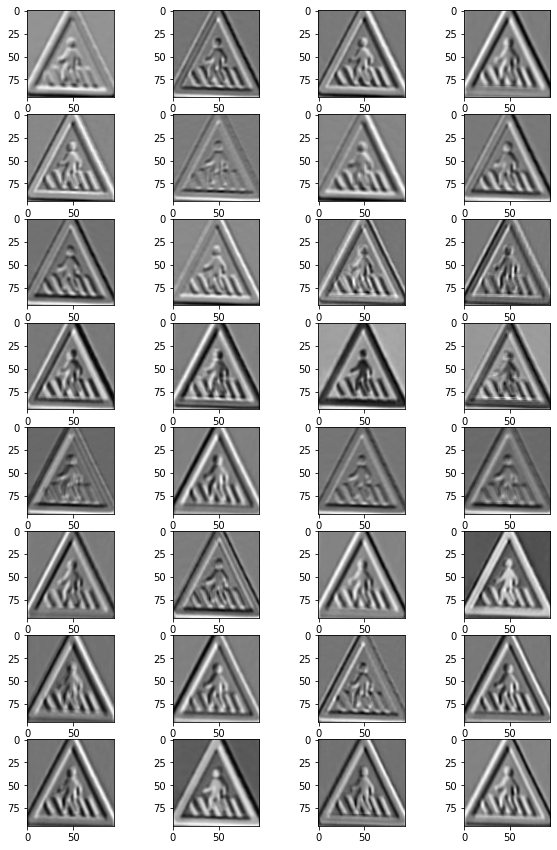

KerasTensor(type_spec=TensorSpec(shape=(None, 90, 90, 32), dtype=tf.float32, name=None), name='conv2d_211/BiasAdd:0', description="created by layer 'conv2d_211'")
32/32 [==============================] - 0s 9ms/step


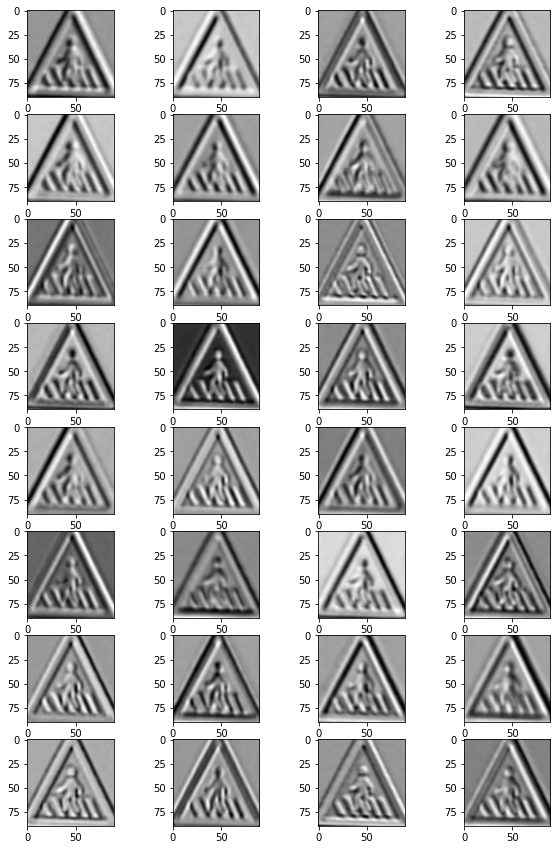

KerasTensor(type_spec=TensorSpec(shape=(None, 85, 85, 32), dtype=tf.float32, name=None), name='conv2d_212/BiasAdd:0', description="created by layer 'conv2d_212'")
32/32 [==============================] - 1s 15ms/step


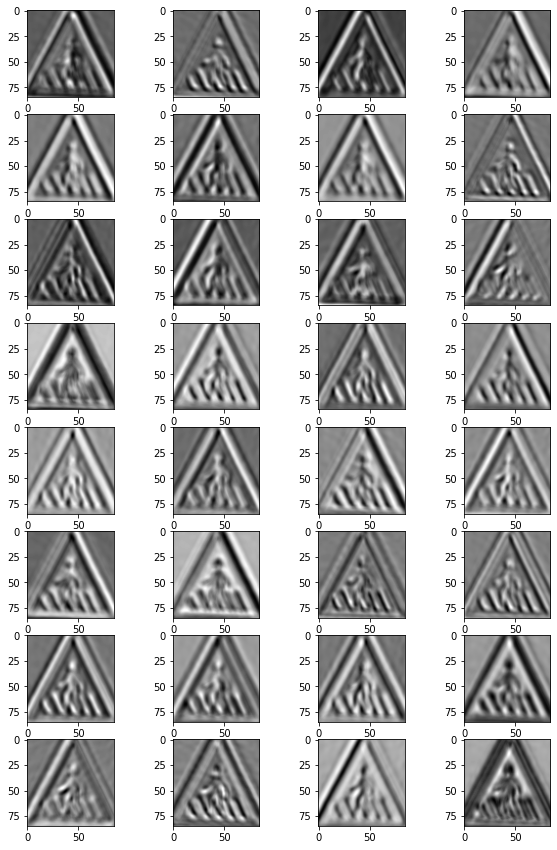

KerasTensor(type_spec=TensorSpec(shape=(None, 40, 40, 64), dtype=tf.float32, name=None), name='conv2d_213/BiasAdd:0', description="created by layer 'conv2d_213'")
32/32 [==============================] - 1s 18ms/step


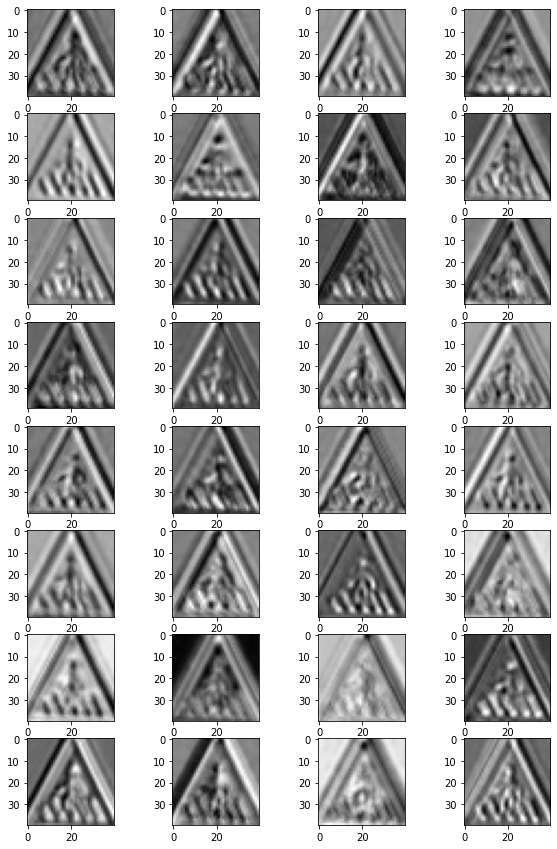

KerasTensor(type_spec=TensorSpec(shape=(None, 38, 38, 64), dtype=tf.float32, name=None), name='conv2d_214/BiasAdd:0', description="created by layer 'conv2d_214'")
32/32 [==============================] - 1s 20ms/step


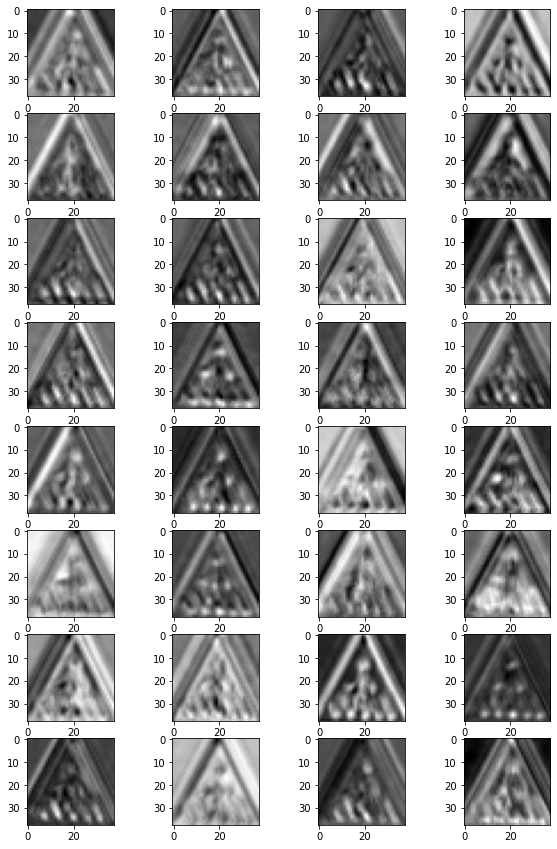

KerasTensor(type_spec=TensorSpec(shape=(None, 36, 36, 64), dtype=tf.float32, name=None), name='conv2d_215/BiasAdd:0', description="created by layer 'conv2d_215'")
32/32 [==============================] - 1s 21ms/step


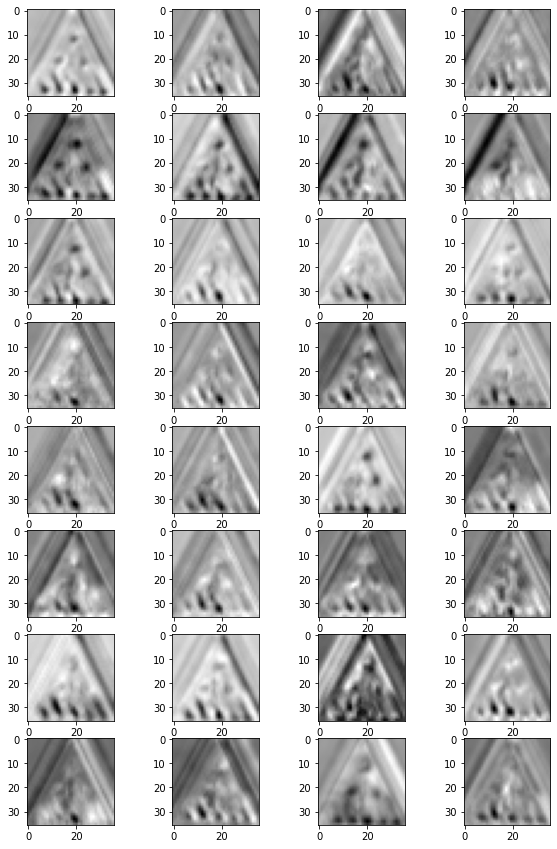

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 32), dtype=tf.float32, name=None), name='conv2d_216/BiasAdd:0', description="created by layer 'conv2d_216'")
32/32 [==============================] - 1s 22ms/step


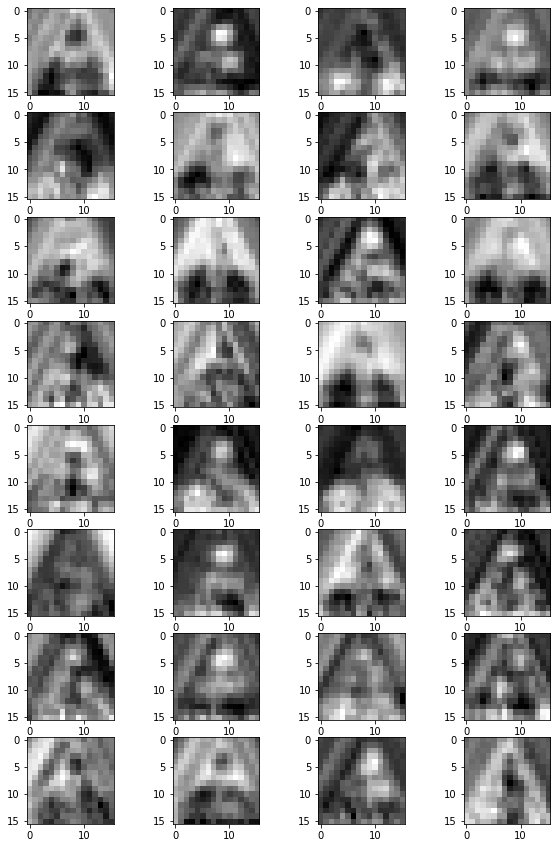

In [49]:
for layer in conv_layers:
  random_image = random.randint(0,len(x_test_gray)-1);
  layer_output = classification_model.get_layer(layer['name']).output
  print(layer_output)
  model = Model(input, layer_output);
  image = model.predict(test_dataset_gray);
  fig = plt.figure(figsize=(10,15));
  for i in range(32):
    plt.subplot(8, 4, i+1);
    plt.imshow(image[0][:,:,i], cmap='gray');
  plt.show();

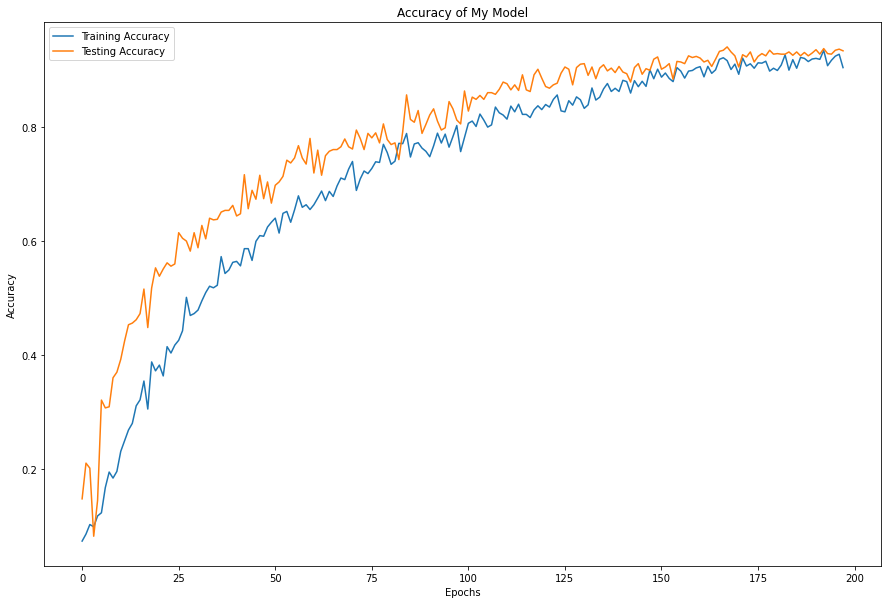

In [85]:
plt.figure(figsize=(15,10))
plt.plot(history.history['accuracy']);
plt.plot(history.history['val_accuracy']);
plt.legend(['Training Accuracy', 'Testing Accuracy']);
plt.title('Accuracy of My Model');
plt.ylabel('Accuracy');
plt.xlabel('Epochs');

In [86]:
pretrained_y_pred = pretrained_model.predict(test_dataset)
y_pred = classification_model.predict(test_dataset_gray)

32/32 [==============================] - 1s 24ms/step


In [87]:
pretrained_predictions = []
predictions = []

for row in pretrained_y_pred:
  pretrained_predictions.append(row.argmax())

for row in y_pred:
  predictions.append(row.argmax())

In [88]:
pretrained_predictions = to_categorical(pretrained_predictions)
predictions = to_categorical(predictions)

In [89]:
accuracy_score(y_test, pretrained_predictions)

0.9706457925636007

In [90]:
accuracy_score(y_test, predictions)

0.9403131115459883

In [91]:
print(classification_report(y_test, pretrained_predictions, target_names=target_names))

              precision    recall  f1-score   support

     limit30       0.91      0.97      0.94        60
     limit50       0.97      0.97      0.97        58
     limit60       0.96      1.00      0.98        50
     limit80       1.00      0.96      0.98        50
      noleft       0.97      1.00      0.98       130
     noright       1.00      0.96      0.98        92
     nouturn       1.00      0.89      0.94        36
  gostraight       1.00      1.00      1.00        12
      goleft       0.57      1.00      0.73         8
     goright       1.00      0.77      0.87        26
   keepright       1.00      0.94      0.97       134
  roundabout       0.75      1.00      0.86        24
      danger       1.00      1.00      1.00         8
pedestrcross       1.00      1.00      1.00        46
   bikecross       1.00      1.00      1.00        12
  childcross       1.00      1.00      1.00        26
  traincross       1.00      1.00      1.00        10
construction       1.00    

In [92]:
print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

     limit30       0.79      0.93      0.85        60
     limit50       1.00      0.93      0.96        58
     limit60       0.68      0.80      0.73        50
     limit80       0.93      0.84      0.88        50
      noleft       1.00      0.94      0.97       130
     noright       0.99      0.92      0.96        92
     nouturn       0.80      0.92      0.86        36
  gostraight       0.75      1.00      0.86        12
      goleft       0.67      0.75      0.71         8
     goright       1.00      1.00      1.00        26
   keepright       0.98      0.95      0.97       134
  roundabout       0.86      1.00      0.92        24
      danger       1.00      1.00      1.00         8
pedestrcross       1.00      1.00      1.00        46
   bikecross       1.00      1.00      1.00        12
  childcross       1.00      1.00      1.00        26
  traincross       0.83      1.00      0.91        10
construction       1.00    

Save trained models

In [ ]:
classification_model.save('my_model');
pretrained_predictions.save('pretrained_model');